# ROMY - Barometer

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np

from pandas import DataFrame
from obspy import read_inventory
from scipy.signal import hilbert

from andbro__read_sds import __read_sds

In [2]:
from functions.get_mean_promy_pressure import __get_mean_promy_pressure
from functions.get_mean_rmy_pressure import __get_mean_rmy_pressure

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

## Configurations

In [4]:
config = {}

# output path for figures
config['path_to_figs'] = data_path+"romy_baro/figures/"

# path to data archive
config['path_to_data'] = data_path+"romy_events/data/"

# path to data sds
config['path_to_sds'] = archive_path+"temp_archive/"


# adjust time interval
config['t1'] = obs.UTCDateTime("2024-03-04 05:00")
config['t2'] = obs.UTCDateTime("2024-03-04 07:00")
config['toffset'] = 3*3600

config['t1'] = obs.UTCDateTime("2024-04-23 02:00")
config['t2'] = obs.UTCDateTime("2024-04-23 05:00")
config['toffset'] = 3*3600

# data
config['tbeg'] = config['t1'] - config['toffset']
config['tend'] = config['t2'] + config['toffset']



# ROMY coordinates
config['sta_lon'] = 11.275501
config['sta_lat'] = 48.162941


## Load Data

In [6]:
# st0 = obs.read(config['path_to_data']+config['filename'], starttime=config['t1'], endtime=config['t2'])

# st0

In [17]:
st0 = obs.Stream()
st0 += __read_sds(config['path_to_sds'], "BW.ROMY.30.BJZ", config['tbeg'], config['tend'])
st0 += __read_sds(config['path_to_sds'], "BW.ROMY.30.BJN", config['tbeg'], config['tend'])
st0 += __read_sds(config['path_to_sds'], "BW.ROMY.30.BJE", config['tbeg'], config['tend'])

st0.merge(fill_value="interpolate")

st0

3 Trace(s) in Stream:
BW.ROMY.30.BJN | 2024-04-22T23:00:00.010999Z - 2024-04-23T08:00:00.010999Z | 20.0 Hz, 648001 samples
BW.ROMY.30.BJE | 2024-04-22T22:59:59.990599Z - 2024-04-23T07:59:59.990599Z | 20.0 Hz, 648001 samples
BW.ROMY.30.BJZ | 2024-04-22T23:00:00.009800Z - 2024-04-23T08:00:00.009800Z | 20.0 Hz, 648001 samples

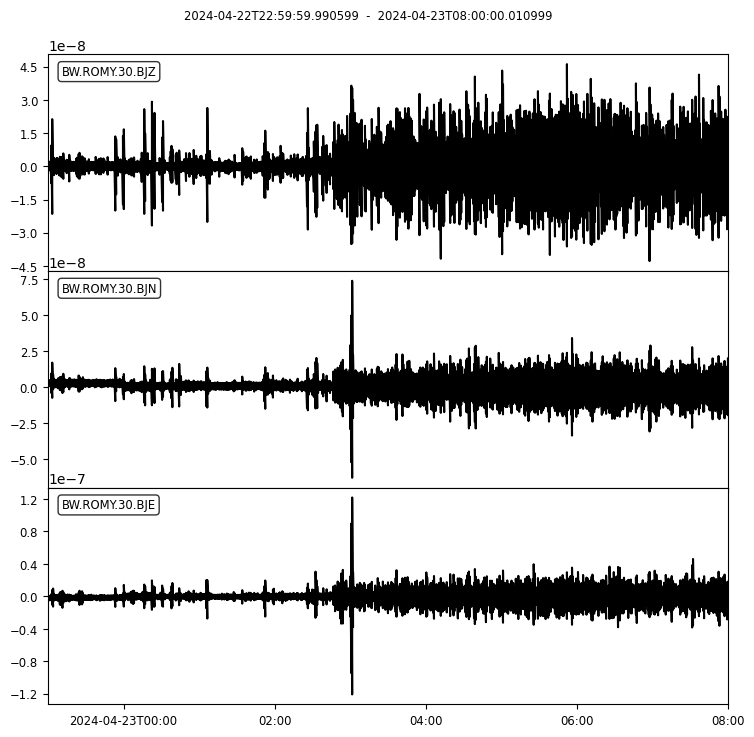

In [18]:
st0.plot(equal_scale=False);

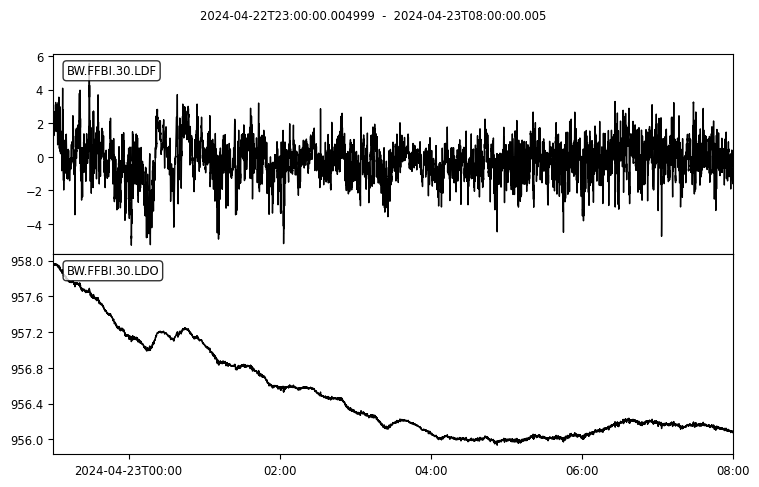

In [11]:
ffbi_inv = read_inventory(root_path+"/Documents/ROMY/ROMY_infrasound/station_BW_FFBI.xml")

ffbi0 = __read_sds(archive_path+"temp_archive/", "BW.FFBI.30.LDF", config['tbeg'], config['tend'])
ffbi0 += __read_sds(archive_path+"temp_archive/", "BW.FFBI.30.LDO", config['tbeg'], config['tend'])

# ffbi0 = __read_sds(bay_path+"mseed_online/archive/", "BW.FFBI..BDF", config['tbeg'], config['tend'])
# ffbi0 += __read_sds(bay_path+"mseed_online/archive/", "BW.FFBI..BDO", config['tbeg'], config['tend'])

# if len(ffbi0) != 2:
#     ffbi0.merge();

# for tr in ffbi0:
#     if "F" in tr.stats.channel:
#         tr = tr.remove_response(ffbi_inv, water_level=10)
#     if "O" in tr.stats.channel:
#         # tr.data = tr.data /1.0 /6.28099e5 /100e-3   # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity = 100 mV/hPa
#         tr.data = tr.data /1.0 /6.28099e5 /1e-5   # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity = 100 mV/hPa

# # ffbi0 = ffbi0.resample(1.0, no_filter=True)

ffbi0.merge();

ffbi0.plot(equal_scale=False);

BW.WROMY.04.LDI | 2024-04-22T23:00:00.000000Z - 2024-04-23T08:00:00.000000Z | 1.0 Hz, 32401 samples
BW.WROMY.05.LDI | 2024-04-22T23:00:00.000000Z - 2024-04-23T08:00:00.000000Z | 1.0 Hz, 32401 samples
BW.WROMY.07.LDI | 2024-04-22T23:00:00.000000Z - 2024-04-23T08:00:00.000000Z | 1.0 Hz, 32401 samples
BW.WROMY.09.LDI | 2024-04-22T23:00:00.000000Z - 2024-04-23T08:00:00.000000Z | 1.0 Hz, 32401 samples


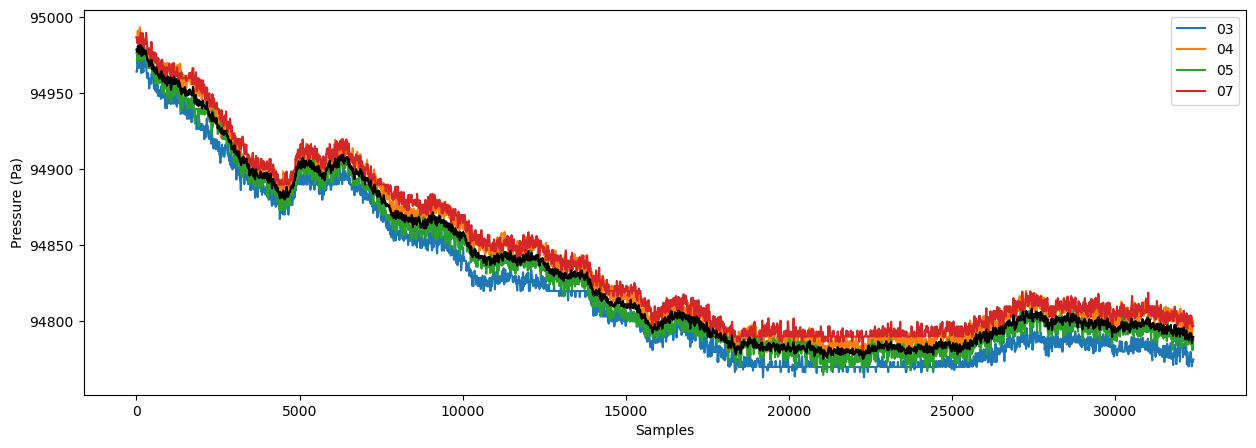

In [111]:
promy = __get_mean_promy_pressure(["03", "04", "05", "07", "09"], config['tbeg'], config['tend'], archive_path, plot=True)

In [97]:
def __get_mean_rmy_pressure(stations, t1, t2, path_to_data, plot=False):

    import matplotlib.pyplot as plt
    from andbro__read_sds import __read_sds
    from obspy import Stream
    from functions.interpolate_nan import __interpolate_nan
    from functions.smoothing import __smooth
    from obspy.signal.cross_correlation import correlate, xcorr_max
    from numpy import arange, roll, array

    ps0 = Stream()

    for jj in stations:
        if jj == "PROMY":
            loc, cha = "03", "LDI"
        else:
            loc, cha = "", "LDO"

        ps0 += __read_sds(path_to_data+"temp_archive/", f"BW.{jj}.{loc}.{cha}", t1-10, t2+10)

    ps0 = ps0.trim(t1, t2)

    # update stations
    stations = []
    for tr in ps0:
        stations.append(tr.stats.station)

        # smooth data
        tr.data = __smooth(tr.data, 30)

    # convert from hPa to Pa
    for tr in ps0:
        if "03" in tr.stats.location:
            tr.data = __interpolate_nan(tr.data)
        else:
            tr.data = tr.data * 100 # scale to Pa
            tr.data = __interpolate_nan(tr.data)

    # equalize number of samples
    npts_min = ps0[0].stats.npts
    for tr in ps0:
        if tr.stats.npts < npts_min:
            npts_min
    for tr in ps0:
        diff = abs(tr.stats.npts - npts_min)
        if diff != 0:
            tr.data = tr.data[:-diff]

    print(ps0)

    ps0 = ps0.detrend("linear")
    ps0 = ps0.detrend("simple")
    ps0 = ps0.filter("highpass", freq=1/(6*3600), corners=4, zerophase=True);

    # shift traces to compute mean of array
    shifted = []

    for i, sta in enumerate(stations):

        if i == 0:
            arr0 = ps0.select(station=sta)[0].data
            shifted.append(arr0)
            continue
        else:
            arr1 = ps0.select(station=sta)[0].data

        Nshift = len(arr0)

        dt = ps0[0].stats.delta

        ccf1 = correlate(arr0, arr1, shift=Nshift, demean=False, normalize='naive', method='fft')

        cclags = arange(-Nshift, Nshift+1) * dt

        shift1, value1 = xcorr_max(ccf1)
        print(shift1, value1)

        arr1_shifted = roll(arr1, shift1)

        shifted.append(arr1_shifted)

        # compute mean
        _mean = array([])
        for i, arr in enumerate(shifted):
            if i == 0:
                _mean = arr
            else:
                _mean = _mean + arr

    mean = ps0[0].copy()
    mean.stats.station = "RMY"
    mean.stats.location = "00"
    mean.stats.channel = "LDO"
    mean.data = _mean/(i+1)

    # checkup plot
    if plot:
        times = ps0[0].times()/3600
        plt.figure(figsize=(15, 5))
        for i, x in enumerate(shifted):
            plt.plot(times, x, label=stations[i], zorder=2)
        plt.plot(times, mean.data, "k", zorder=2)
        plt.legend()
        plt.grid(ls="--", color="grey", alpha=0.4)
        plt.ylabel("Pressure (Pa)", fontsize=12)
        plt.xlabel("Time (hour)", fontsize=12)
        plt.show();

    return mean, fig

 -> failed to obtain waveforms!
5 Trace(s) in Stream:
BW.PROMY.03.LDI | 2024-04-22T23:00:00.000000Z - 2024-04-23T08:00:00.000000Z | 1.0 Hz, 32401 samples
BW.ALFT..LDO    | 2024-04-22T23:00:00.000000Z - 2024-04-23T08:00:00.000000Z | 1.0 Hz, 32401 samples
BW.BIB..LDO     | 2024-04-22T23:00:00.000000Z - 2024-04-23T08:00:00.000000Z | 1.0 Hz, 32401 samples
BW.GELB..LDO    | 2024-04-22T23:00:00.000000Z - 2024-04-23T08:00:00.000000Z | 1.0 Hz, 32401 samples
BW.GRMB..LDO    | 2024-04-22T23:00:00.000000Z - 2024-04-23T08:00:00.000000Z | 1.0 Hz, 32401 samples
78 0.9685180786689038
0 0.9718283473619254
0 0.9837720290130884
65 0.9722495142658899


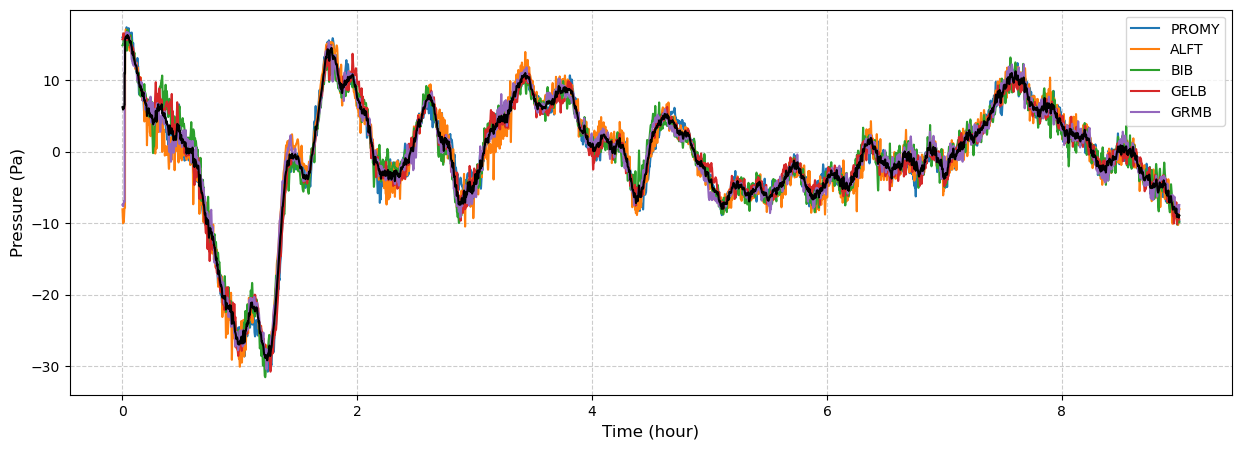

In [109]:
brmy, _ = __get_mean_rmy_pressure(["PROMY", "ALFT", "TON", "BIB", "GELB", "GRMB"],
                                  config['tbeg'], config['tend'],
                                  archive_path,
                                  plot=True,
                                 )

7 Trace(s) in Stream:
BW.ROMY.30.BJN  | 2024-04-22T23:00:00.010999Z - 2024-04-23T07:59:59.010999Z | 1.0 Hz, 32400 samples
BW.ROMY.30.BJE  | 2024-04-22T22:59:59.990599Z - 2024-04-23T07:59:58.990599Z | 1.0 Hz, 32400 samples
BW.ROMY.30.BJZ  | 2024-04-22T23:00:00.009800Z - 2024-04-23T07:59:59.009800Z | 1.0 Hz, 32400 samples
BW.FFBI.30.LDF  | 2024-04-22T23:00:00.004999Z - 2024-04-23T08:00:00.004999Z | 1.0 Hz, 32401 samples
BW.FFBI.30.LDO  | 2024-04-22T23:00:00.005000Z - 2024-04-23T08:00:00.005000Z | 1.0 Hz, 32401 samples
BW.PROMY.00.LDI | 2024-04-22T23:00:00.000000Z - 2024-04-23T08:00:00.000000Z | 1.0 Hz, 32401 samples
BW.RMY.00.LDO   | 2024-04-22T23:00:00.000000Z - 2024-04-23T08:00:00.000000Z | 1.0 Hz, 32401 samples


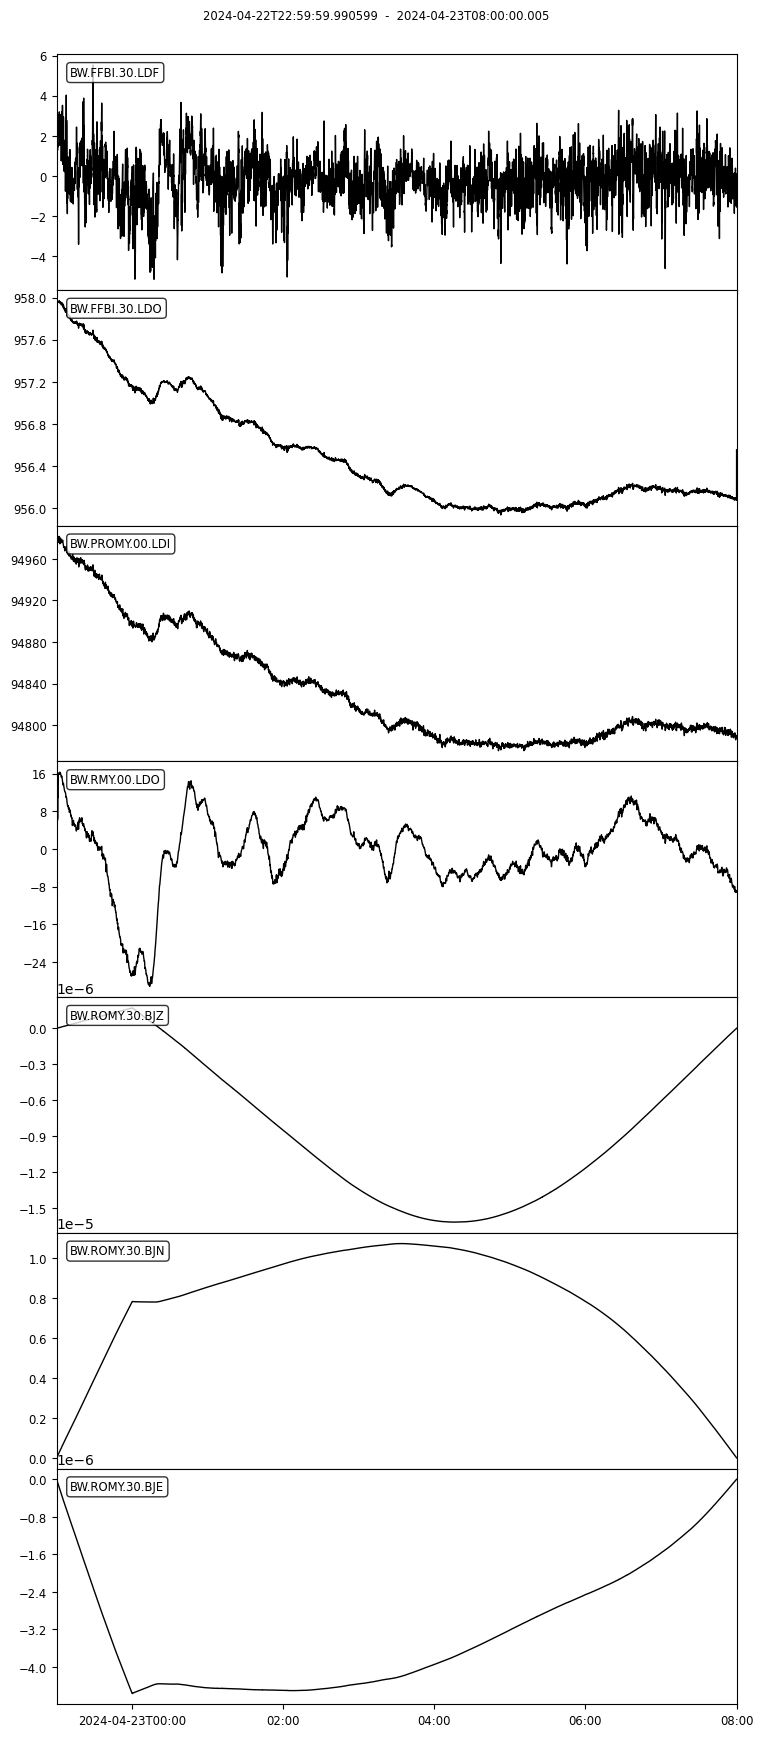

In [113]:
from scipy import integrate

til1 = st0.select(station=f"ROMY", channel="*J*").copy()

til1 = til1.detrend("demean")

# til1 = til1.integrate("spline")
til1 = til1.integrate("cumtrapz")

# for tr in til1:

stt = obs.Stream()

stt += til1.copy()
stt += ffbi0.copy()

stt = stt.resample(10.0, no_filter=True)
stt = stt.resample(1.0, no_filter=True)

try:
    stt += promy.copy()
except:
    pass
try:
    stt += brmy.copy()
except:
    pass

print(stt)

stt.plot(equal_scale=False);

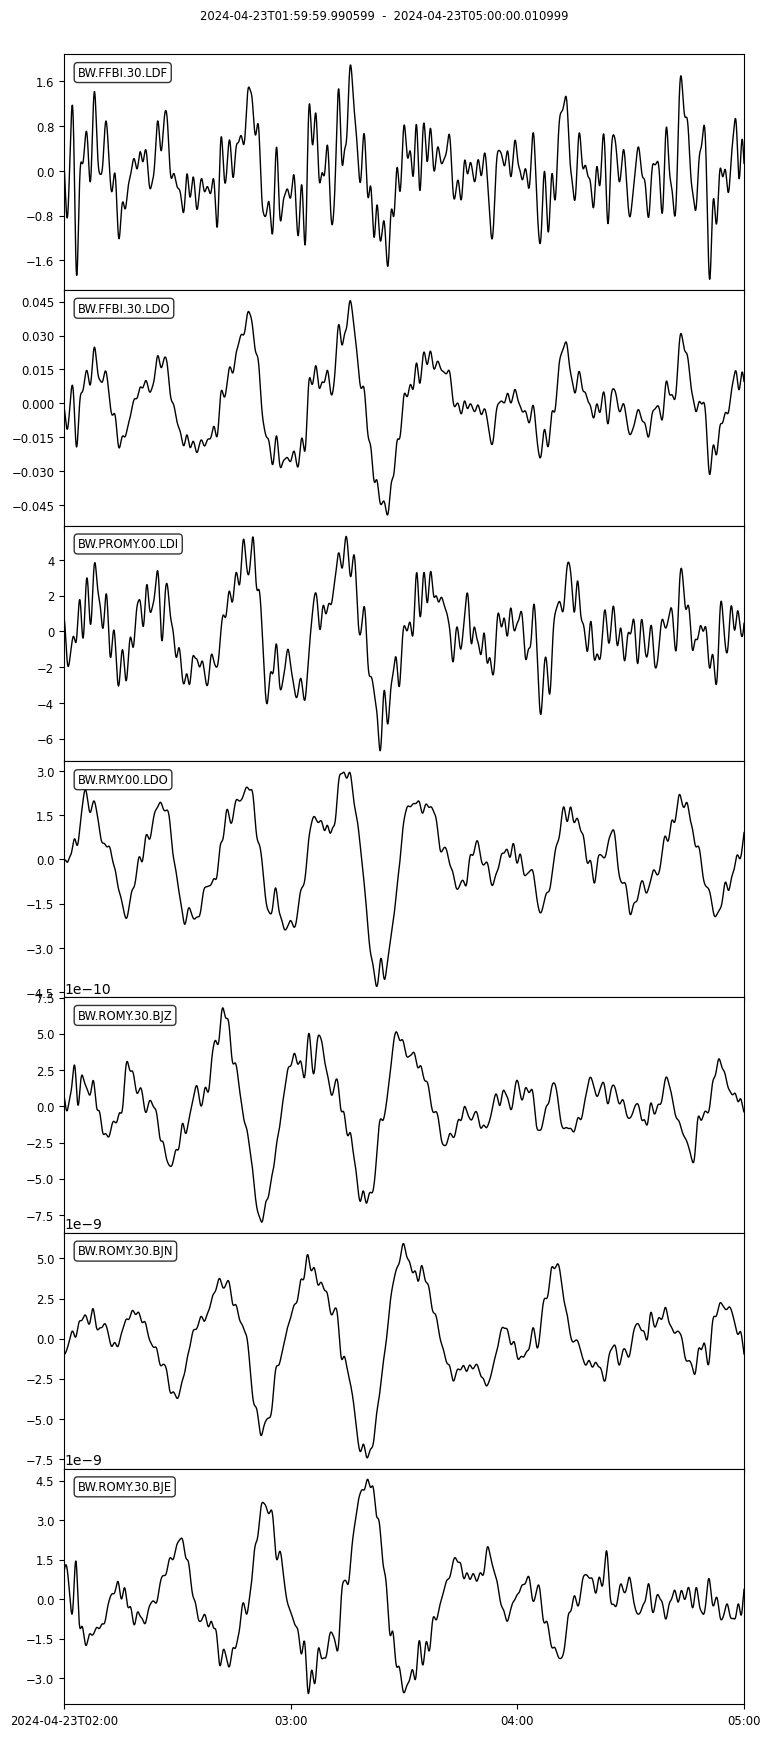

In [114]:
# fmin, fmax = 0.001, 0.01
# fmin, fmax = 0.001, 0.005
fmin, fmax = 0.0005, 0.01

stt = stt.detrend("demean")
stt = stt.detrend("linear")

stt = stt.taper(0.05)

stt = stt.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);

stt = stt.trim(config['t1'], config['t2'])

for tr in til1:
    tr.data = tr.data[:-1]


stt.plot(equal_scale=False);


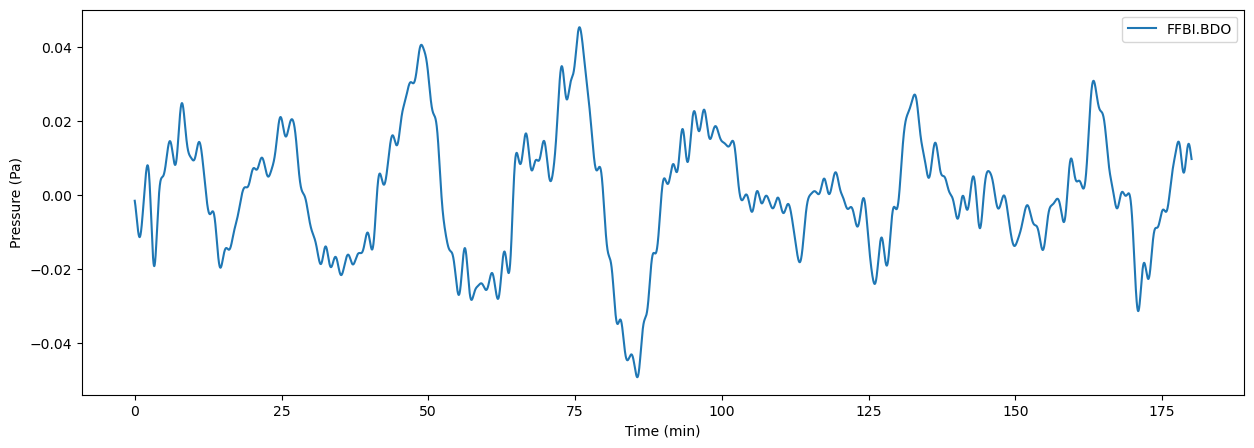

In [115]:
plt.figure(figsize=(15, 5))

tt = stt[0].times()/60

# plt.plot(tt, stt.select(channel="BDF")[0].data, label="FFBI.BDF")
plt.plot(tt, stt.select(channel="*DO")[0].data, label="FFBI.BDO")
# plt.plot(tt, stt.select(station="PROMY")[0].data, label="PROMY.LDI")
# plt.plot(tt, stt.select(station="RMY")[0].data, label="RMY.LDO")
plt.legend()
plt.ylabel("Pressure (Pa)")
plt.xlabel("Time (min)")
plt.show();

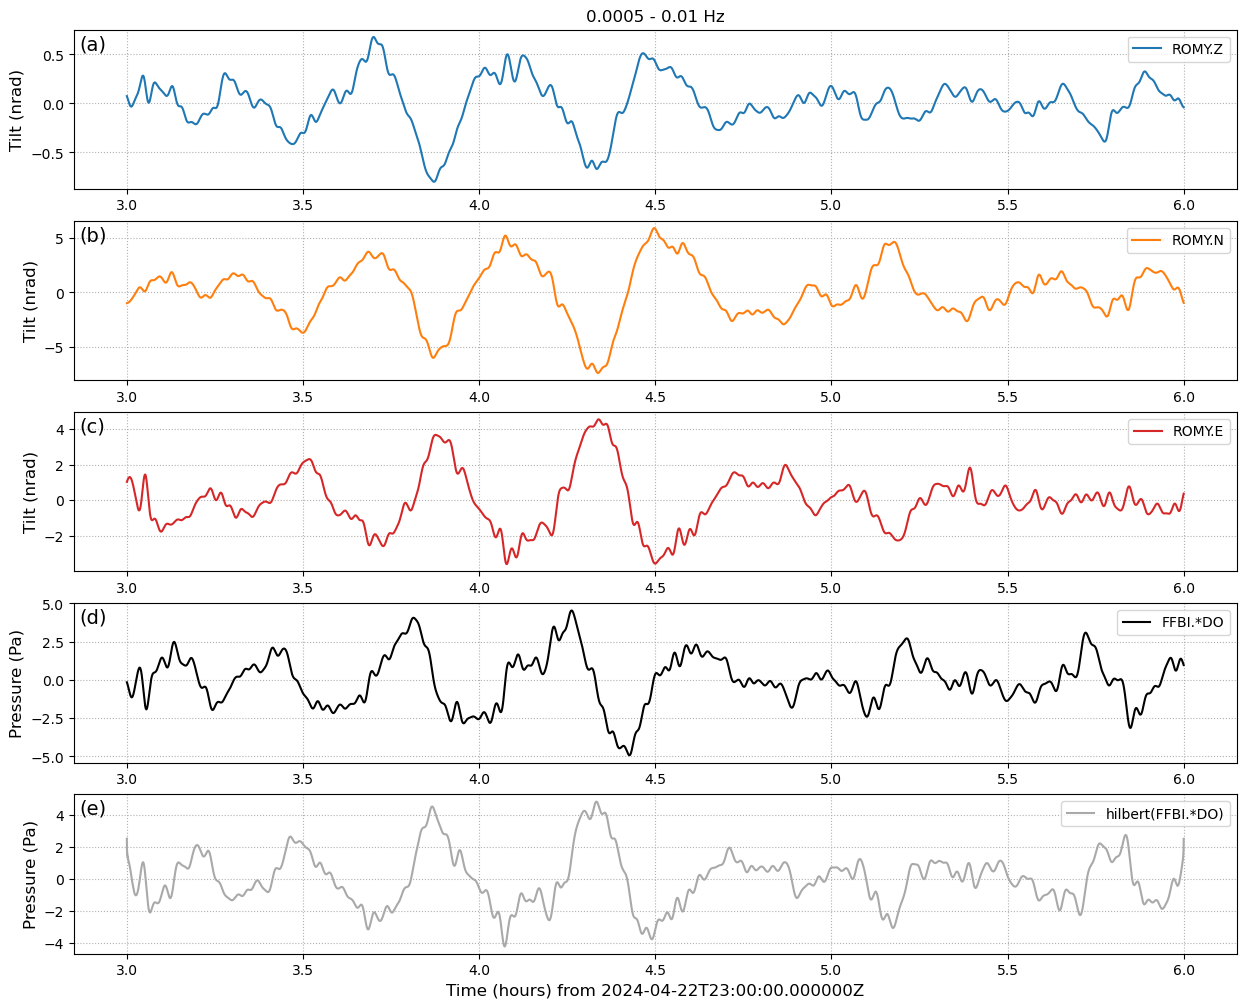

In [102]:
def __makeplot():

    from scipy.signal import hilbert
    from numpy import imag

    Nrow, Ncol = 5, 1

    yscale = 1e9

    font = 12

    ch = "*DO"

    tscale, tunit = 1/3600, "hours"

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 12))

    ax[0].plot(stt.select(component="Z")[0].times(reftime=config['tbeg'])*tscale,
               stt.select(component="Z")[0].data*yscale,
               label="ROMY.Z", color="tab:blue")

    ax[1].plot(stt.select(component="N")[0].times(reftime=config['tbeg'])*tscale,
               stt.select(component="N")[0].data*yscale,
               label="ROMY.N", color="tab:orange")

    ax[2].plot(stt.select(component="E")[0].times(reftime=config['tbeg'])*tscale,
               stt.select(component="E")[0].data*yscale,
               label="ROMY.E", color="tab:red")

    ax[3].plot(stt.select(channel=ch)[0].times(reftime=config['tbeg'])*tscale,
               stt.select(channel=ch)[0].data*100,
               label=f"FFBI.{ch}", color="k")

    ax[4].plot(stt.select(channel=ch)[0].times(reftime=config['tbeg'])*tscale,
               imag(hilbert(stt.select(channel=ch)[0].data))*100,
               label=f"hilbert(FFBI.{ch})", color="darkgrey")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax[0].set_ylabel("Tilt (nrad)", fontsize=font)
    ax[1].set_ylabel("Tilt (nrad)", fontsize=font)
    ax[2].set_ylabel("Tilt (nrad)", fontsize=font)

    ax[3].set_ylabel("Pressure (Pa)", fontsize=font)
    ax[4].set_ylabel("Pressure (Pa)", fontsize=font)

    ax[Nrow-1].set_xlabel(f"Time ({tunit}) from {config['tbeg']}", fontsize=font)

    ax[0].set_title(f"{fmin} - {fmax} Hz")

    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)', '(e)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)

    plt.show();
    return fig


fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"RB_{config['tbeg'].date}_waveforms.png", format="png", dpi=150, bbox_inches='tight')


In [50]:
def __makeplot():

    from scipy.signal import hilbert
    from numpy import imag

    Nrow, Ncol = 2, 2

    ch = "O"

    font = 12

    yscale = 1e9

    tscale, tunit = 1/3600, "hours"

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    ax[0, 0].scatter(imag(hilbert(stt.select(component=ch)[0].data)),
                    stt.select(component="N")[0].data*yscale,
                    label="ROMY-N", color="tab:orange", s=5
                    )
    ax[0, 0].set_xlabel("H(Pressure) (Pa)", fontsize=font)
    ax[0, 0].set_ylabel("Tilt (nrad)", fontsize=font)

    ax[0, 1].scatter(stt.select(component=ch)[0].data,
                    stt.select(component="N")[0].data*yscale,
                    label="ROMY-N", color="tab:orange", s=5,
                    )
    ax[0, 1].set_xlabel("Pressure (Pa)", fontsize=font)
    ax[0, 1].set_ylabel("Tilt (nrad)", fontsize=font)

    ax[1, 0].scatter(imag(hilbert(stt.select(component=ch)[0].data)),
                    stt.select(component="E")[0].data*yscale,
                    label="ROMY-E", color="tab:red", s=5
                    )
    ax[1, 0].set_xlabel("H(Pressure) (Pa)", fontsize=font)
    ax[1, 0].set_ylabel("Tilt (nrad)", fontsize=font)

    ax[1, 1].scatter(stt.select(component=ch)[0].data,
                    stt.select(component="E")[0].data*yscale,
                    label="ROMY-E", color="tab:red", s=5
                    )
    ax[1, 1].set_xlabel("Pressure (Pa)", fontsize=font)
    ax[1, 1].set_ylabel("Tilt (nrad)", fontsize=font)

    for j in range(2):
        for i in range(2):
            ax[i, j].grid(ls=":", zorder=0)
            ax[i, j].legend(loc=1)
            # ax[i, j].set_title(f"{fmin} - {fmax} Hz", fontsize=font)

    plt.show();
    return fig

# fig = __makeplot();

# fig.savefig("/home/andbro/Desktop/FürRuedi/"+"waveforms_scatter.png")

Nshift:  -325 Tshift:  -325.0 CC:  -0.7902535699281028
Nshift:  -362 Tshift:  -362.0 CC:  0.7877148610044271


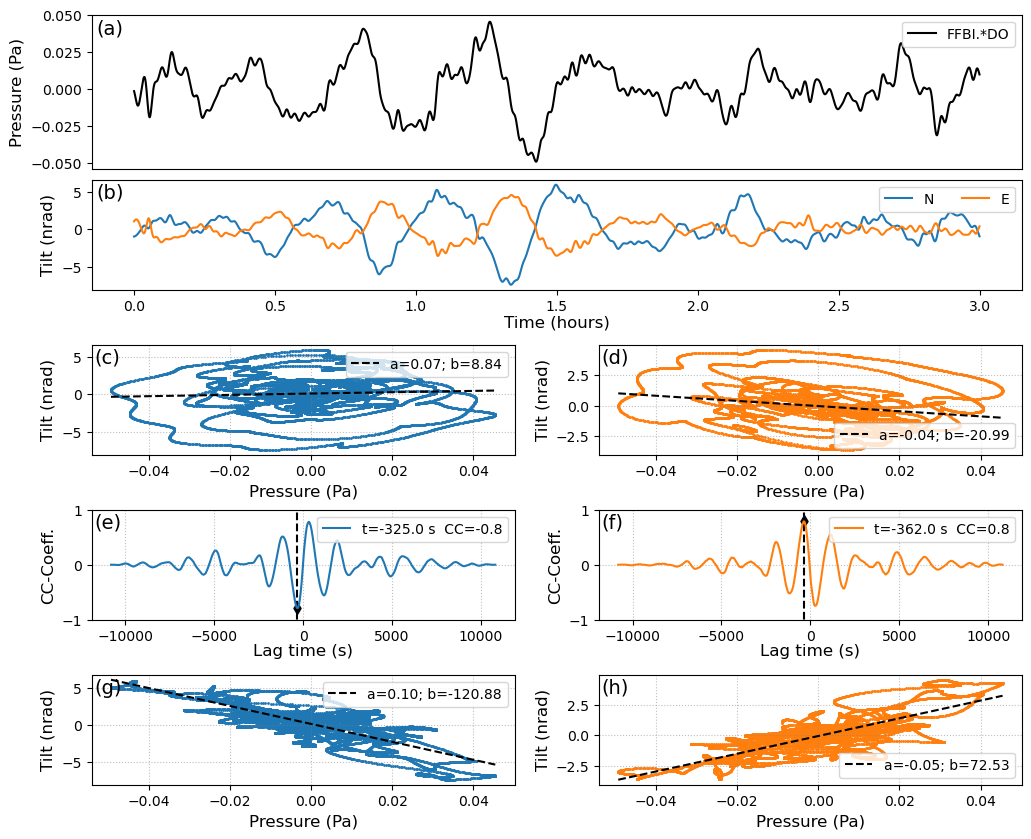

In [52]:
def __compare_tilt_pressure(st0):

    from obspy.signal.cross_correlation import correlate, xcorr_max
    from numpy import nan_to_num, arange, array, linspace, imag, roll
    from matplotlib.gridspec import GridSpec
    from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
    from functions.smoothing import __smooth
    from scipy.signal import hilbert

    tlp = st0.copy()

    dt = tlp[0].stats.delta

    times = tlp[0].times()/3600

    ch = "*DO"

    arr0 = tlp.select(channel=ch)[0].data
    arr1 = tlp.select(component="N")[0].data
    arr2 = tlp.select(component="E")[0].data


    Nshift = len(arr0)

    ccf1 = correlate(arr0, arr1, shift=Nshift, demean=False, normalize='naive', method='fft')
    ccf2 = correlate(arr0, arr2, shift=Nshift, demean=False, normalize='naive', method='fft')

    cclags = arange(-Nshift, Nshift+1) * dt

    shift1, value1 = xcorr_max(ccf1)
    shift2, value2 = xcorr_max(ccf2)

    arr1_shifted = roll(arr1, shift1)
    arr2_shifted = roll(arr2, shift2)

    print("Nshift: ", shift1, "Tshift: ", shift1*dt, "CC: ", value1)
    print("Nshift: ", shift2, "Tshift: ", shift2*dt, "CC: ", value2)


    b1, a1 = __compute_orthogonal_distance_regression(arr0, arr1, xerr=None, yerr=None, bx=None, by=None)
    b2, a2 = __compute_orthogonal_distance_regression(arr0, arr2, xerr=None, yerr=None, bx=None, by=None)

    b1_shifted, a1_shifted = __compute_orthogonal_distance_regression(arr0, arr1_shifted, xerr=None, yerr=None, bx=None, by=None)
    b2_shifted, a2_shifted = __compute_orthogonal_distance_regression(arr0, arr2_shifted, xerr=None, yerr=None, bx=None, by=None)

    xxx = linspace(arr0.min(), arr0.max(), 100)

    Nrow, Ncol = 5, 2
    font = 12

    fig = plt.figure(figsize=(12, 10))

    gs0 = GridSpec(Nrow, Ncol, figure=fig, hspace=0)
    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.5)

    ax1 = fig.add_subplot(gs0[0, :])
    ax2 = fig.add_subplot(gs[1, :])
    ax3 = fig.add_subplot(gs[2, :1])
    ax4 = fig.add_subplot(gs[2, 1:])
    ax5 = fig.add_subplot(gs[3, :1])
    ax6 = fig.add_subplot(gs[3, 1:])
    ax7 = fig.add_subplot(gs[4, :1])
    ax8 = fig.add_subplot(gs[4, 1:])

    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
    for _k, (ax, ll) in enumerate(zip(axes, ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)'])):
        ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)

    plt.subplots_adjust(hspace=0.35)

    ax1.plot(times, arr0, color="black", label=f"FFBI.{ch}")
    ax1.set_ylabel("Pressure (Pa)", fontsize=font)
    ax1.get_xaxis().set_visible(False)
    ax1.legend(loc=1)

    ax2.plot(times, arr1*1e9, label="N")
    ax2.plot(times, arr2*1e9, label="E")
    ax2.legend(loc=1, ncol=2)
    ax2.set_ylabel("Tilt (nrad)", fontsize=font)
    ax2.set_xlabel("Time (hours)", fontsize=font, labelpad=1)


    ax3.scatter(arr0, arr1*1e9, color="tab:blue", s=1)
    ax3.plot(xxx, (a1+b1*xxx)*1e9, ls="--", color="k", label=f"a={a1*1e9:.2f}; b={b1*1e9:.2f}")
    ax3.set_xlabel("Pressure (Pa)", fontsize=font)
    ax3.set_ylabel("Tilt (nrad)", fontsize=font)
    ax3.legend(loc=1)

    ax4.scatter(arr0, arr2*1e9, color="tab:orange", s=1)
    ax4.plot(xxx, (a2+b2*xxx)*1e9, ls="--", color="k", label=f"a={a2*1e9:.2f}; b={b2*1e9:.2f}")
    ax4.set_xlabel("Pressure (Pa)", fontsize=font)
    ax4.set_ylabel("Tilt (nrad)", fontsize=font)
    ax4.legend(loc=4)

    ll = f"t={round(shift1*dt, 1)} s  CC={round(value1, 1)}"
    ax5.plot(cclags, ccf1, color="tab:blue", label=ll)
    ax5.set_ylabel("CC-Coeff.", fontsize=font)
    ax5.set_xlabel("Lag time (s)", fontsize=font, labelpad=0)
    ax5.set_ylim(-1, 1)
    ax5.axvline(shift1*dt, -1, 1, color="k", ls="--", zorder=0)
    ax5.scatter(shift1*dt, value1, color="k", marker="d", zorder=0)
    ax5.legend(loc=1)
    # ax5.text(.005, .97, ll, ha='left', va='top', transform=ax3.transAxes, fontsize=font)

    ll = f"t={round(shift2*dt, 1)} s  CC={round(value2, 1)}"
    ax6.plot(cclags, ccf2, color="tab:orange", label=ll)
    ax6.set_ylabel("CC-Coeff.", fontsize=font)
    ax6.set_xlabel("Lag time (s)", fontsize=font, labelpad=0)
    ax6.set_ylim(-1, 1)
    ax6.axvline(shift2*dt, -1, 1, color="k", ls="--", zorder=0)
    ax6.scatter(shift2*dt, value2, color="k", marker="d", zorder=0)
    ax6.legend(loc=1)
    # ax6.text(.005, .97, ll, ha='left', va='top', transform=ax4.transAxes, fontsize=font)


    ax7.scatter(arr0, arr1_shifted*1e9, color="tab:blue", s=1)
    ax7.plot(xxx, (a1_shifted+b1_shifted*xxx)*1e9, ls="--", color="k", label=f"a={a1_shifted*1e9:.2f}; b={b1_shifted*1e9:.2f}")
    ax7.set_xlabel("Pressure (Pa)", fontsize=font)
    ax7.set_ylabel("Tilt (nrad)", fontsize=font)
    ax7.legend(loc=1)

    ax8.scatter(arr0, arr2_shifted*1e9, color="tab:orange", s=1)
    ax8.plot(xxx, (a2_shifted+b2_shifted*xxx)*1e9, ls="--", color="k", label=f"a={a2_shifted*1e9:.2f}; b={b2_shifted*1e9:.2f}")
    ax8.set_xlabel("Pressure (Pa)", fontsize=font)
    ax8.set_ylabel("Tilt (nrad)", fontsize=font)
    ax8.legend(loc=4)

    for ax in [ax3, ax4, ax5, ax6, ax7, ax8]:
        ax.grid(ls=":", alpha=0.5, zorder=0, color="grey")

    plt.show();
    return fig

fig = __compare_tilt_pressure(stt)

# fig.savefig(config['path_to_figs']+f"RB__{config['tbeg'].date}_waveforms_cc.png", format="png", dpi=150, bbox_inches='tight')


Nshift:  -16 Tshift:  -16.0 CC:  -0.9174717965278896
Nshift:  -33 Tshift:  -33.0 CC:  0.8957243044079735


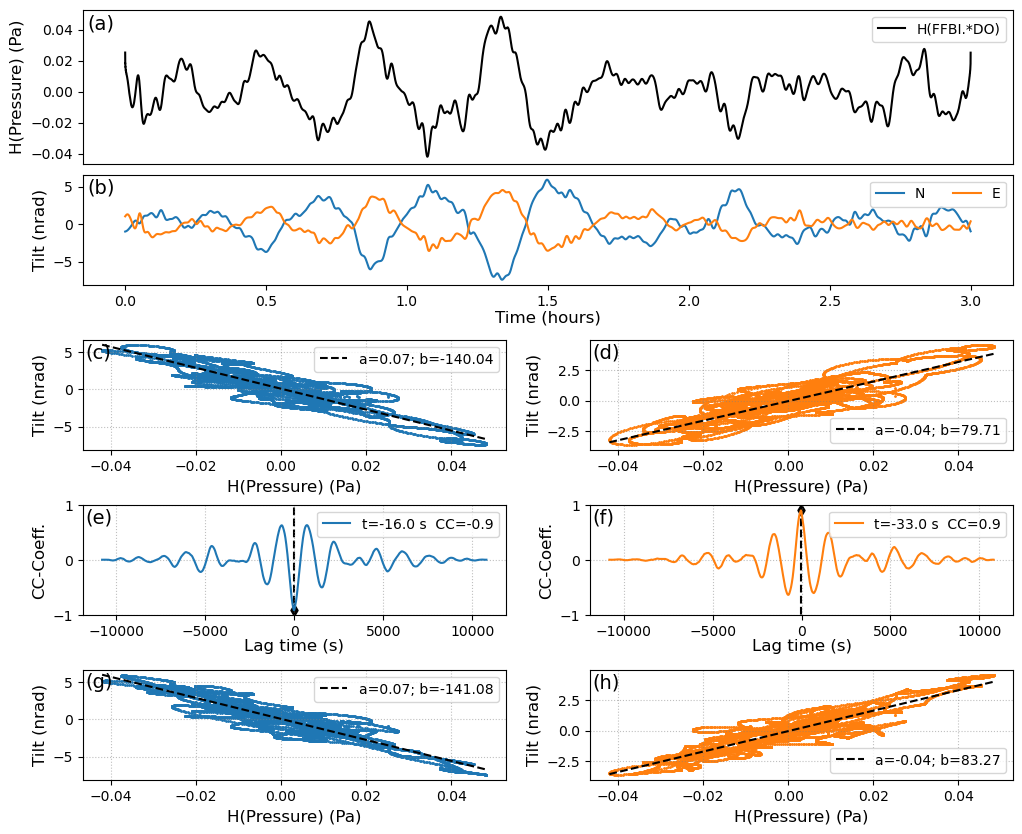

In [54]:
def __compare_tilt_pressure(st0):

    from obspy.signal.cross_correlation import correlate, xcorr_max
    from numpy import nan_to_num, arange, array, linspace, imag, roll
    from matplotlib.gridspec import GridSpec
    from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
    from functions.smoothing import __smooth
    from scipy.signal import hilbert

    tlp = st0.copy()

    dt = tlp[0].stats.delta

    times = tlp[0].times()/3600

    yscale = 1e9

    ch = "*DO"

    arr0 = imag(hilbert(tlp.select(channel=ch)[0].data))
    arr1 = tlp.select(component="N")[0].data
    arr2 = tlp.select(component="E")[0].data

    Nshift = len(arr0)

    ccf1 = correlate(arr0, arr1, shift=Nshift, demean=False, normalize='naive', method='fft')
    ccf2 = correlate(arr0, arr2, shift=Nshift, demean=False, normalize='naive', method='fft')

    cclags = arange(-Nshift, Nshift+1) * dt

    shift1, value1 = xcorr_max(ccf1)
    shift2, value2 = xcorr_max(ccf2)

    arr1_shifted = roll(arr1, shift1)
    arr2_shifted = roll(arr2, shift2)

    print("Nshift: ", shift1, "Tshift: ", shift1*dt, "CC: ", value1)
    print("Nshift: ", shift2, "Tshift: ", shift2*dt, "CC: ", value2)


    b1, a1 = __compute_orthogonal_distance_regression(arr0, arr1, xerr=None, yerr=None, bx=None, by=None)
    b2, a2 = __compute_orthogonal_distance_regression(arr0, arr2, xerr=None, yerr=None, bx=None, by=None)

    b1_shifted, a1_shifted = __compute_orthogonal_distance_regression(arr0, arr1_shifted, xerr=None, yerr=None, bx=None, by=None)
    b2_shifted, a2_shifted = __compute_orthogonal_distance_regression(arr0, arr2_shifted, xerr=None, yerr=None, bx=None, by=None)

    xxx = linspace(arr0.min(), arr0.max(), 100)

    Nrow, Ncol = 5, 2
    font = 12

    fig = plt.figure(figsize=(12, 10))

    gs0 = GridSpec(Nrow, Ncol, figure=fig, hspace=0)
    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.5)

    ax1 = fig.add_subplot(gs0[0, :])
    ax2 = fig.add_subplot(gs[1, :])
    ax3 = fig.add_subplot(gs[2, :1])
    ax4 = fig.add_subplot(gs[2, 1:])
    ax5 = fig.add_subplot(gs[3, :1])
    ax6 = fig.add_subplot(gs[3, 1:])
    ax7 = fig.add_subplot(gs[4, :1])
    ax8 = fig.add_subplot(gs[4, 1:])

    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
    for _k, (ax, ll) in enumerate(zip(axes, ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)'])):
        ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)

    plt.subplots_adjust(hspace=0.35)

    ax1.plot(times, arr0, color="black", label=f"H(FFBI.{ch})")
    ax1.set_ylabel("H(Pressure) (Pa)", fontsize=font)
    ax1.get_xaxis().set_visible(False)
    ax1.legend(loc=1)

    ax2.plot(times, arr1*yscale, label="N")
    ax2.plot(times, arr2*yscale, label="E")
    ax2.legend(ncol=2)
    ax2.set_ylabel("Tilt (nrad)", fontsize=font)
    ax2.set_xlabel("Time (hours)", fontsize=font, labelpad=1)


    ax3.scatter(arr0, arr1*yscale, color="tab:blue", s=1)
    ax3.plot(xxx, (a1+b1*xxx)*yscale, ls="--", color="k", label=f"a={a1*1e9:.2f}; b={b1*yscale:.2f}")
    ax3.set_xlabel("H(Pressure) (Pa)", fontsize=font)
    ax3.set_ylabel("Tilt (nrad)", fontsize=font)
    ax3.legend(loc=1)

    ax4.scatter(arr0, arr2*yscale, color="tab:orange", s=1)
    ax4.plot(xxx, (a2+b2*xxx)*yscale, ls="--", color="k", label=f"a={a2*1e9:.2f}; b={b2*yscale:.2f}")
    ax4.set_xlabel("H(Pressure) (Pa)", fontsize=font)
    ax4.set_ylabel("Tilt (nrad)", fontsize=font)
    ax4.legend(loc=4)

    ll = f"t={round(shift1*dt, 1)} s  CC={round(value1, 1)}"
    ax5.plot(cclags, ccf1, color="tab:blue", label=ll)
    ax5.set_ylabel("CC-Coeff.", fontsize=font)
    ax5.set_xlabel("Lag time (s)", fontsize=font, labelpad=0)
    ax5.set_ylim(-1, 1)
    ax5.axvline(shift1*dt, -1, 1, color="k", ls="--", zorder=0)
    ax5.scatter(shift1*dt, value1, color="k", marker="d", zorder=0)
    ax5.legend(loc=1)
    # ax5.text(.005, .97, ll, ha='left', va='top', transform=ax3.transAxes, fontsize=font)

    ll = f"t={round(shift2*dt, 1)} s  CC={round(value2, 1)}"
    ax6.plot(cclags, ccf2, color="tab:orange", label=ll)
    ax6.set_ylabel("CC-Coeff.", fontsize=font)
    ax6.set_xlabel("Lag time (s)", fontsize=font, labelpad=0)
    ax6.set_ylim(-1, 1)
    ax6.axvline(shift2*dt, -1, 1, color="k", ls="--", zorder=0)
    ax6.scatter(shift2*dt, value2, color="k", marker="d", zorder=0)
    ax6.legend(loc=1)
    # ax6.text(.005, .97, ll, ha='left', va='top', transform=ax4.transAxes, fontsize=font)

    ax7.scatter(arr0, arr1_shifted*yscale, color="tab:blue", s=1)
    ax7.plot(xxx, (a1_shifted+b1_shifted*xxx)*yscale, ls="--", color="k", label=f"a={a1_shifted*yscale:.2f}; b={b1_shifted*1e9:.2f}")
    ax7.set_xlabel("H(Pressure) (Pa)", fontsize=font)
    ax7.set_ylabel("Tilt (nrad)", fontsize=font)
    ax7.legend(loc=1)

    ax8.scatter(arr0, arr2_shifted*yscale, color="tab:orange", s=1)
    ax8.plot(xxx, (a2_shifted+b2_shifted*xxx)*yscale, ls="--", color="k", label=f"a={a2_shifted*yscale:.2f}; b={b2_shifted*1e9:.2f}")
    ax8.set_xlabel("H(Pressure) (Pa)", fontsize=font)
    ax8.set_ylabel("Tilt (nrad)", fontsize=font)
    ax8.legend(loc=4)

    for ax in [ax3, ax4, ax5, ax6, ax7, ax8]:
        ax.grid(ls=":", alpha=0.5, zorder=0, color="grey")


    plt.show();
    return fig

fig = __compare_tilt_pressure(stt)

# fig.savefig(config['path_to_figs']+f"RB_{config['tbeg'].date}_waveforms_cc_hilbert.png", format="png", dpi=150, bbox_inches='tight')


## Estimate Linear Coefficients

In [55]:
def __estimate_linear_coefficients(st0, c1="N", c2="O", c3=None):

    from scipy.signal import hilbert
    from numpy import imag, array, linalg, vstack

    if c3 is None:
        c3 = c2

    # pressure
    pp = st0.select(channel=c2)[0].data

    # hilbert(pressure)
    hp = imag(hilbert(st0.select(channel=c3)[0].data))

    # data
    dd = st0.select(channel=c1)[0].data

    # matrix
    A = vstack([pp, hp]).T

    # least squares
    a, b = linalg.lstsq(A, dd, rcond=None)[0]

    # estimate of data
    hh = a*pp + b*hp

    # residual
    rr = dd - hh

    return a, b, hh, rr

In [56]:
def __variance_reduction(arr1, arr2):

    from numpy import var

    sig1 = var(arr1)
    sig2 = var(arr2)

    return round( (sig1 - sig2) / sig1 * 100, 2)

In [59]:
c2 = "*DO" # pressure
c3 = "*DO" # hilbert of pressure

a_Z, b_Z, hh_Z, res_Z = __estimate_linear_coefficients(stt, c1="BJZ", c2=c2, c3=c3)

# Vertical
dd_Z = stt.select(component="Z")[0].data
pp_Z = stt.select(channel=c2)[0].data

R_Z = __variance_reduction(dd_Z, res_Z)

tt_Z = stt.select(component="Z")[0].times()


# North
a_N, b_N, hh_N, res_N = __estimate_linear_coefficients(stt, c1="BJN", c2=c2, c3=c3)

dd_N = stt.select(component="N")[0].data
pp_N = stt.select(channel=c2)[0].data

R_N = __variance_reduction(dd_N, res_N)

tt_N = stt.select(component="N")[0].times()

# East
a_E, b_E, hh_E, res_E = __estimate_linear_coefficients(stt, c1="BJE", c2=c2, c3=c3)

dd_E = stt.select(component="E")[0].data
pp_E = stt.select(channel=c2)[0].data

R_E = __variance_reduction(dd_E, res_E)

tt_E = stt.select(component="E")[0].times()


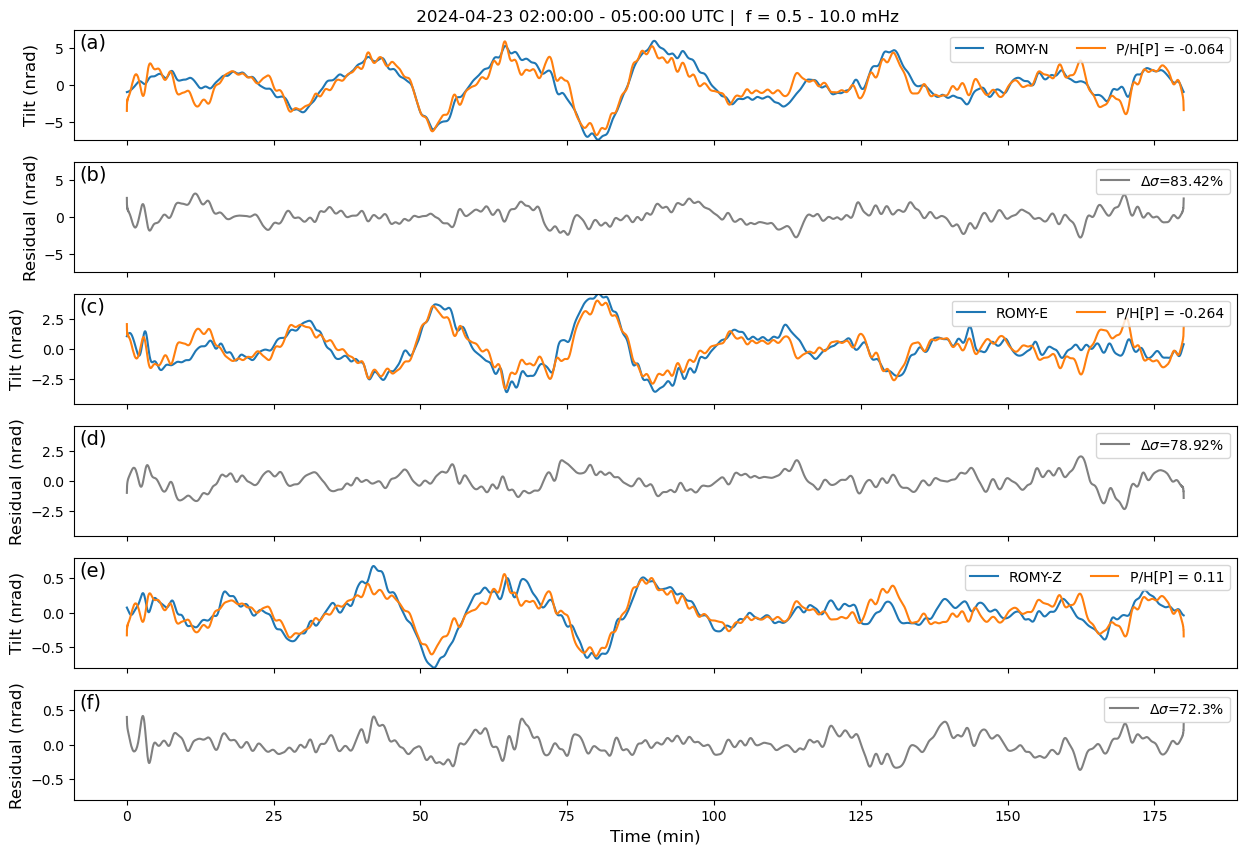

In [201]:
def __makeplot4():

    Nrow, Ncol = 6, 1

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    font = 12

    yscale, yunit = 1e9, "nrad"

    tscale, tunit = 1/60, "min"

    dsig = r"$\Delta \sigma$"

    y_max = max([max(abs(dd_N*yscale)), max(abs(hh_N*yscale))])

    ax[0].plot(tt_N*tscale, dd_N*yscale, label="ROMY-N")
    ax[0].plot(tt_N*tscale, hh_N*yscale, label=f"P/H[P] = {round(a_N/b_N, 3)}")
    # ax[0].plot(tt_N*tscale, hh_N*yscale, label=f"{round(a_N*1e12, 2)}e12 * P+{round(b_N*1e12, 2)}e12 * H[P]")
    ax[0].set_ylim(-y_max, y_max)
    ax[0].set_ylabel(f"Tilt ({yunit})", fontsize=font)

    ax[1].plot(tt_N*tscale, ( dd_N - hh_N )*yscale, color="grey", label=f"{dsig}={R_N}%")
    ax[1].set_ylim(-y_max, y_max)
    ax[1].set_ylabel(f"Residual ({yunit})", fontsize=font)


    y_max = max([max(abs(dd_E*yscale)), max(abs(hh_E*yscale))])

    ax[2].plot(tt_E*tscale, dd_E*yscale, label="ROMY-E")
    ax[2].plot(tt_E*tscale, hh_E*yscale, label=f"P/H[P] = {round(a_E/b_E, 3)}")
    ax[2].set_ylim(-y_max, y_max)
    ax[2].set_ylabel(f"Tilt ({yunit})", fontsize=font)

    ax[3].plot(tt_E*tscale, ( dd_E - hh_E )*yscale, color="grey", label=f"{dsig}={R_E}%")
    ax[3].set_ylim(-y_max, y_max)
    ax[3].set_ylabel(f"Residual ({yunit})", fontsize=font)


    y_max = max([max(abs(dd_Z*yscale)), max(abs(hh_Z*yscale))])

    ax[4].plot(tt_Z*tscale, dd_Z*yscale, label="ROMY-Z")
    ax[4].plot(tt_Z*tscale, hh_Z*yscale, label=f"P/H[P] = {round(a_Z/b_Z, 3)}")
    ax[4].set_ylim(-y_max, y_max)
    ax[4].set_ylabel(f"Tilt ({yunit})", fontsize=font)

    ax[5].plot(tt_Z*tscale, ( dd_Z - hh_Z )*yscale, color="grey", label=f"{dsig}={R_Z}%")
    ax[5].set_ylim(-y_max, y_max)
    ax[5].set_ylabel(f"Residual ({yunit})", fontsize=font)


    ax[Nrow-1].set_xlabel(f"Time ({tunit})", fontsize=font)

    ax[0].set_title(f" {config['t1'].date} {str(config['t1'].time).split('.')[0]} - {str(config['t2'].time).split('.')[0]} UTC |  f = {fmin*1e3} - {fmax*1e3} mHz", fontsize=font)

    for i in range(Nrow):
        ax[i].legend(loc=1, ncol=2)

    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)


    plt.show();
    return fig

fig = __makeplot4()

# fig.savefig(config['path_to_figs']+f"RB_{config['tbeg'].date}_waveforms_corrected.png", format="png", dpi=150, bbox_inches='tight')


### Estimate Model

In [63]:
from functions.regression import __regression

In [75]:
def __regression(ddf, _features, target="fj_fs", reg="theilsen"):

    from sklearn import linear_model
    from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor
    from numpy import array

    _df = ddf.copy()

    # remove time and target
    try:
        _features.remove(target)
    except:
        pass
    try:
        _features.remove("time")
    except:
        pass

    print(_features)

    # define x data
    X = _df[_features].values.reshape(-1, len(_features))

    # define y data
    y = _df[target].values

    # multi linear regression

    # using OLS
    if reg.lower() == "ols":
        ols = linear_model.LinearRegression()
        model = ols.fit(X, y)

        print("R2:", model.score(X, y))
        print("X0:",  model.intercept_)
        print("Coef: ",  model.coef_)
        for _f, _c in zip(_features, model.coef_):
            print(f"{_f} : {_c}")

    elif reg.lower() == "ransac":
        model = RANSACRegressor(random_state=1).fit(X, y)
        print("R2:", model.score(X, y))
        print("IC: ", model.estimator_.intercept_)
        print("Coef: ",  model.estimator_.coef_)
        for _f, _c in zip(_features, model.estimator_.coef_):
            print(f"{_f} : {_c}")

    # using TheilSen
    elif reg.lower() == "theilsen":
        model = TheilSenRegressor().fit(X, y)

        print("R2:", model.score(X, y))
        print("X0:",  model.intercept_)
        print("Coef: ",  model.coef_)
        for _f, _c in zip(_features, model.coef_):
            print(f"{_f} : {_c}")

    # prediction
    model_predict = []

    for o, row in _df[_features].iterrows():

        x_pred = []
        for feat in _features:
            x_pred.append(row[feat])

        x_pred = array(x_pred)
        x_pred = x_pred.reshape(-1, len(_features))

        model_predict.append(model.predict(x_pred))

    # prepare putput dict
    out = {}

    out['model'] = model
    out['r2'] = model.score(X, y)
    out['tp'] = _df.time
    out['dp'] = model_predict

    if reg.lower() == "ransac":
        out['slope'] = model.estimator_.coef_
        out['inter'] = model.estimator_.intercept_
    elif reg.lower() == "theilsen":
        out['slope'] = model.coef_
        out['inter'] = model.intercept_
    elif reg.lower() == "ols":
        out['slope'] = model.coef_
        out['inter'] = model.intercept_

    # plt.plot(_df.time, model_predict)
    # plt.plot(_df.time, _df[target].values)

    return out

In [123]:
dff = DataFrame()

dff['time'] = stt[0].times()
dff['ffbPP'] = stt.select(station="FFBI", channel="*O")[0].data
dff['ffbHP'] = np.imag(hilbert(stt.select(station="FFBI", channel="*O")[0].data))

dff['rmyPP'] = stt.select(station="RMY", channel="*O")[0].data
dff['rmyHP'] = np.imag(hilbert(stt.select(station="RMY", channel="*O")[0].data))

for c in ["N", "E", "Z"]:
    dff[c] = stt.select(location="30", channel=f"*{c}")[0].data

# model Z ffbi
outZ = __regression(dff, ['ffbPP', 'ffbHP'], target='Z', reg='ransac')

xx_Z0 = outZ['slope'][0]*dff['ffbPP'] + outZ['slope'][1]*dff['ffbHP']
re_Z0 = dff['Z'] - xx_Z0
vr_Z0 = __variance_reduction(xx_Z0, dff['Z'] - xx_Z0)
ra_Z0 = round(outZ['slope'][0]/outZ['slope'][1], 3)

# model N ffbi
outN = __regression(dff, ['ffbPP', 'ffbHP'], target='N', reg='ransac')

xx_N0 = outN['slope'][0]*dff['ffbPP'] + outN['slope'][1]*dff['ffbHP']
re_N0 = dff['N'] - xx_N0
vr_N0 = __variance_reduction(xx_N0, dff['N'] - xx_N0)
ra_N0 = round(outN['slope'][0]/outN['slope'][1], 3)

# model E ffbi
outE = __regression(dff, ['ffbPP', 'ffbHP'], target='E', reg='ransac')

xx_E0 = outE['slope'][0]*dff['ffbPP'] + outE['slope'][1]*dff['ffbHP']
re_E0 = dff['E'] - xx_E0
vr_E0 = __variance_reduction(xx_E0, dff['E'] - xx_E0)
ra_E0 = round(outE['slope'][0]/outE['slope'][1], 3)


# model Z rmy
outZ = __regression(dff, ['rmyPP', 'rmyHP'], target='Z', reg='ransac')

xx_Z1 = outZ['slope'][0]*dff['rmyPP'] + outZ['slope'][1]*dff['rmyHP']
re_Z1 = dff['Z'] - xx_Z1
vr_Z1 = __variance_reduction(xx_Z1, dff['Z'] - xx_Z1)
ra_Z1 = round(outZ['slope'][0]/outZ['slope'][1], 3)

# model N rmy
outN = __regression(dff, ['rmyPP', 'rmyHP'], target='N', reg='ransac')

xx_N1 = outN['slope'][0]*dff['rmyPP'] + outN['slope'][1]*dff['rmyHP']
re_N1 = dff['N'] - xx_N1
vr_N1 = __variance_reduction(xx_N1, dff['N'] - xx_N1)
ra_N1 = round(outN['slope'][0]/outN['slope'][1], 3)

# model E rmy
outE = __regression(dff, ['rmyPP', 'rmyHP'], target='E', reg='ransac')

xx_E1 = outE['slope'][0]*dff['rmyPP'] + outE['slope'][1]*dff['rmyHP']
re_E1 = dff['E'] - xx_E1
vr_E1 = __variance_reduction(xx_E1, dff['E'] - xx_E1)
ra_E1 = round(outE['slope'][0]/outE['slope'][1], 3)


['ffbPP', 'ffbHP']
R2: 0.6762137027068581
IC:  4.282534911922793e-11
Coef:  [-2.89108116e-09 -1.50707693e-08]
ffbPP : -2.891081155138168e-09
ffbHP : -1.5070769332452453e-08
['ffbPP', 'ffbHP']
R2: 0.8215052460494275
IC:  -1.0167711139221999e-10
Coef:  [ 6.11467738e-09 -1.53474706e-07]
ffbPP : 6.114677383223356e-09
ffbHP : -1.5347470607813038e-07
['ffbPP', 'ffbHP']
R2: 0.7749980757433146
IC:  1.3692178949738913e-10
Coef:  [-1.83644871e-08  8.16826364e-08]
ffbPP : -1.8364487130499105e-08
ffbHP : 8.168263639085564e-08
['rmyPP', 'rmyHP']
R2: 0.3488746547655839
IC:  -3.523975640864474e-11
Coef:  [-4.15072630e-11 -7.03416732e-11]
rmyPP : -4.150726300190472e-11
rmyHP : -7.034167318649225e-11
['rmyPP', 'rmyHP']
R2: 0.6819494634425275
IC:  -2.373915020848413e-10
Coef:  [ 2.50888921e-10 -1.60876870e-09]
rmyPP : 2.5088892091372883e-10
rmyHP : -1.608768696015973e-09
['rmyPP', 'rmyHP']
R2: 0.6719905857183431
IC:  -8.058909834696131e-11
Coef:  [-3.11024105e-10  8.79559457e-10]
rmyPP : -3.110241054589

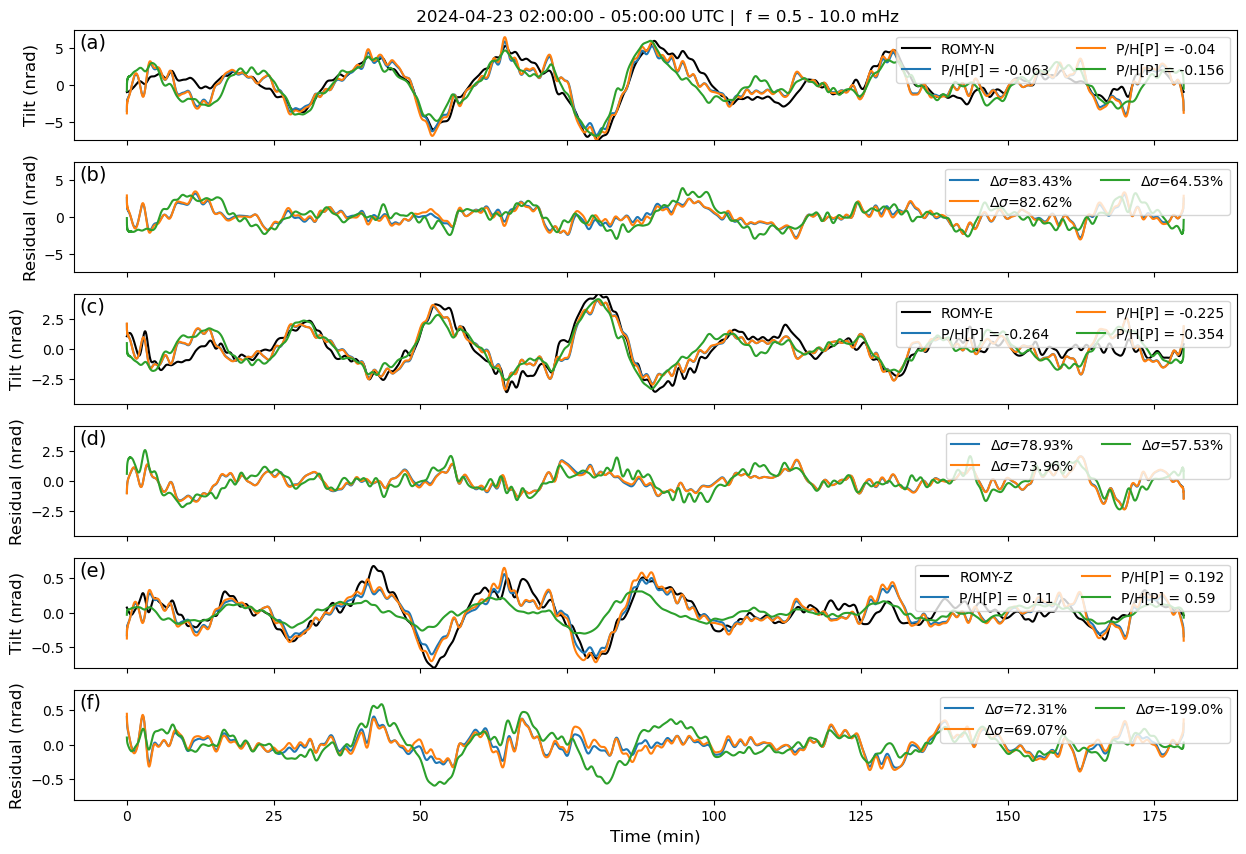

In [129]:
def __makeplot5():

    Nrow, Ncol = 6, 1

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    font = 12

    ls = "-"

    yscale, yunit = 1e9, "nrad"

    tscale, tunit = 1/60, "min"

    dsig = r"$\Delta \sigma$"

    y_max = max([max(abs(dd_N*yscale)), max(abs(hh_N*yscale))])

    ax[0].plot(tt_N*tscale, dd_N*yscale, label="ROMY-N", color="k")
    ax[0].plot(tt_N*tscale, hh_N*yscale, label=f"P/H[P] = {round(a_N/b_N, 3)}")
    ax[0].plot(tt_N*tscale, xx_N0*yscale, label=f"P/H[P] = {ra_N0}")
    ax[0].plot(tt_N*tscale, xx_N1*yscale, label=f"P/H[P] = {ra_N1}")
    ax[0].set_ylim(-y_max, y_max)
    ax[0].set_ylabel(f"Tilt ({yunit})", fontsize=font)

    ax[1].plot(tt_N*tscale, ( dd_N - hh_N )*yscale, label=f"{dsig}={R_N}%", ls=ls)
    ax[1].plot(tt_N*tscale, re_N0*yscale, label=f"{dsig}={vr_N0}%", ls=ls)
    ax[1].plot(tt_N*tscale, re_N1*yscale, label=f"{dsig}={vr_N1}%", ls=ls)
    ax[1].set_ylim(-y_max, y_max)
    ax[1].set_ylabel(f"Residual ({yunit})", fontsize=font)


    y_max = max([max(abs(dd_E*yscale)), max(abs(hh_E*yscale))])

    ax[2].plot(tt_E*tscale, dd_E*yscale, label="ROMY-E", color="k")
    ax[2].plot(tt_E*tscale, hh_E*yscale, label=f"P/H[P] = {round(a_E/b_E, 3)}")
    ax[2].plot(tt_E*tscale, xx_E0*yscale, label=f"P/H[P] = {ra_E0}")
    ax[2].plot(tt_E*tscale, xx_E1*yscale, label=f"P/H[P] = {ra_E1}")

    ax[2].set_ylim(-y_max, y_max)
    ax[2].set_ylabel(f"Tilt ({yunit})", fontsize=font)

    ax[3].plot(tt_E*tscale, ( dd_E - hh_E )*yscale, label=f"{dsig}={R_E}%", ls=ls)
    ax[3].plot(tt_E*tscale, re_E0*yscale, label=f"{dsig}={vr_E0}%", ls=ls)
    ax[3].plot(tt_E*tscale, re_E1*yscale, label=f"{dsig}={vr_E1}%", ls=ls)
    ax[3].set_ylim(-y_max, y_max)
    ax[3].set_ylabel(f"Residual ({yunit})", fontsize=font)


    y_max = max([max(abs(dd_Z*yscale)), max(abs(hh_Z*yscale))])

    ax[4].plot(tt_Z*tscale, dd_Z*yscale, label="ROMY-Z", color="k")
    ax[4].plot(tt_Z*tscale, hh_Z*yscale, label=f"P/H[P] = {round(a_Z/b_Z, 3)}")
    ax[4].plot(tt_Z*tscale, xx_Z0*yscale, label=f"P/H[P] = {ra_Z0}")
    ax[4].plot(tt_Z*tscale, xx_Z1*yscale, label=f"P/H[P] = {ra_Z1}")
    ax[4].set_ylim(-y_max, y_max)
    ax[4].set_ylabel(f"Tilt ({yunit})", fontsize=font)

    ax[5].plot(tt_Z*tscale, ( dd_Z - hh_Z )*yscale, label=f"{dsig}={R_Z}%", ls=ls)
    ax[5].plot(tt_Z*tscale, re_Z0*yscale, label=f"{dsig}={vr_Z0}%", ls=ls)
    ax[5].plot(tt_Z*tscale, re_Z1*yscale, label=f"{dsig}={vr_Z1}%", ls=ls)
    ax[5].set_ylim(-y_max, y_max)
    ax[5].set_ylabel(f"Residual ({yunit})", fontsize=font)

    ax[Nrow-1].set_xlabel(f"Time ({tunit})", fontsize=font)

    ax[0].set_title(f" {config['t1'].date} {str(config['t1'].time).split('.')[0]} - {str(config['t2'].time).split('.')[0]} UTC |  f = {fmin*1e3} - {fmax*1e3} mHz", fontsize=font)

    for i in range(Nrow):
        ax[i].legend(loc=1, ncol=2)

    for _k, ll in enumerate(['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)

    plt.show();
    return fig

fig = __makeplot5()


In [61]:
st1 = obs.Stream()
st1 += stt.select(component="Z").copy()
st1 += stt.select(component="N").copy()
st1 += stt.select(component="E").copy()

st2 = st1.copy()
st2.select(component="Z")[0].data = res_Z
st2.select(component="N")[0].data = res_N
st2.select(component="E")[0].data = res_E


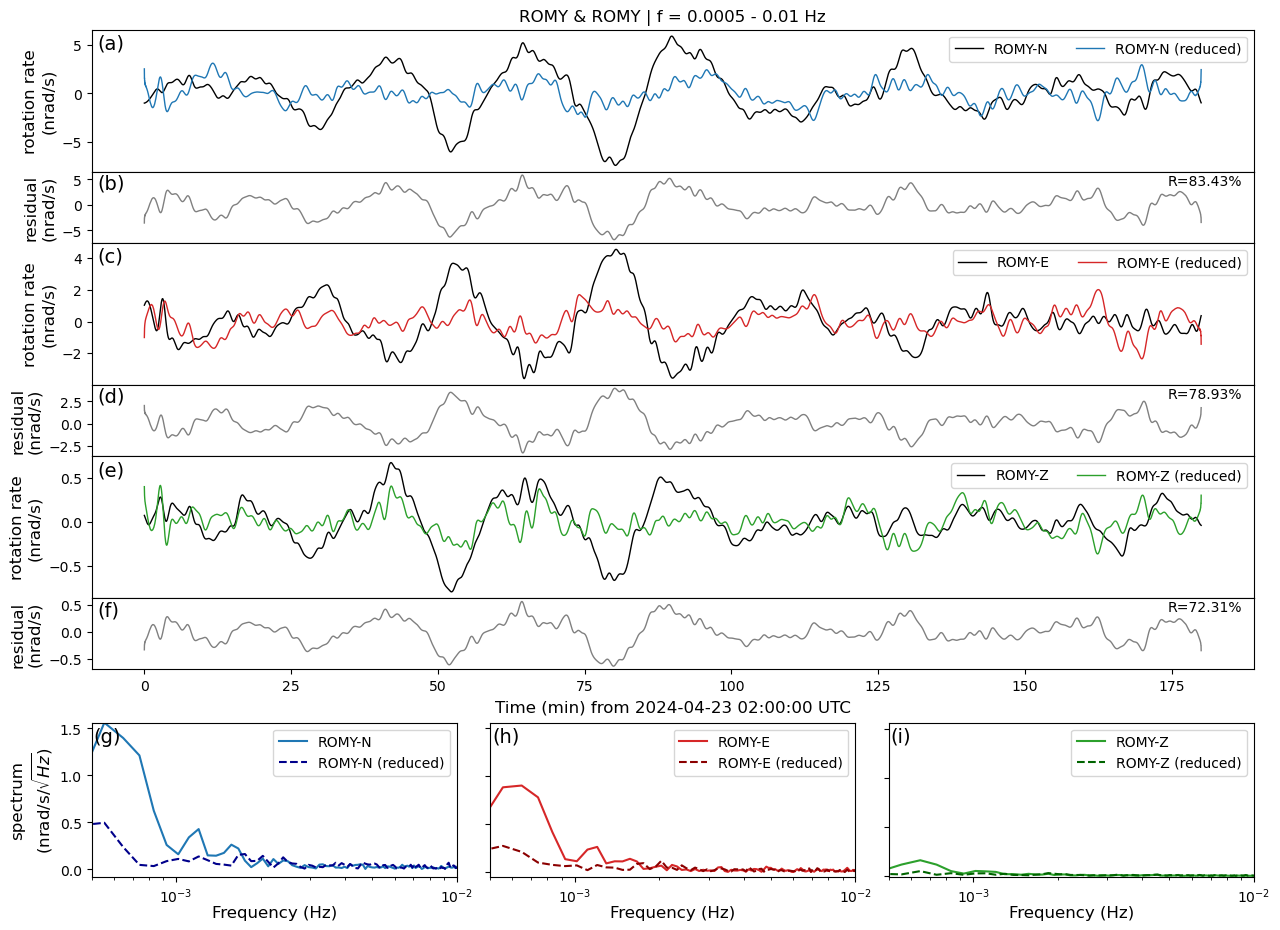

In [62]:
def __makeplot_comparison(st1, st2):

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    from functions.multitaper_psd import __multitaper_psd
    from functions.welch_psd import __welch_psd
    from functions.get_fft import __get_fft


    def __integrate(stt, dat):
        _st = stt.copy()
        _st.data = dat
        _st.integrate()
        return _st.data

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 4)

    def __get_residual_percent(dat1, dat2):
        imax, vmax = np.argmax(abs(dat2-dat1)), np.amax(abs(dat2-dat1))
        pmax = round(np.amax(dat2-dat1)/dat1[imax]*100, 2)
        return pmax

    def __to_dB(psd):
        return 10*np.log10(psd)

    def __get_lim(arrs):
        mins = [min(arr) for arr in arrs]
        maxs = [max(arr) for arr in arrs]
        return min(mins + maxs), max(mins + maxs)


    tscale, tunit = 1/60, "min"

    times = st1.select(channel="*N")[0].times()

    Ncol, Nrow = 6, 13

    font = 12

    lw = 1

    scale, unit = 1e9, f"nrad/s"

    fig = plt.figure(figsize=(15, 12))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0)
    gs2 = GridSpec(Nrow, Ncol, figure=fig, hspace=10000)

    ax1 = fig.add_subplot(gs[0:2, :])
    ax2 = fig.add_subplot(gs[2, :])
    ax3 = fig.add_subplot(gs[3:5, :])
    ax4 = fig.add_subplot(gs[5, :])
    ax5 = fig.add_subplot(gs[6:8, :])
    ax6 = fig.add_subplot(gs[8, :])

    ax7 = fig.add_subplot(gs2[9:12, 0:2])
    ax8 = fig.add_subplot(gs2[9:12, 2:4])
    ax9 = fig.add_subplot(gs2[9:12, 4:6])

    accN = st1.select(channel="*N")[0].data*scale
    accE = st1.select(channel="*E")[0].data*scale
    accZ = st1.select(channel="*Z")[0].data*scale

    accN_c = st2.select(channel="*N")[0].data*scale
    accE_c = st2.select(channel="*E")[0].data*scale
    accZ_c = st2.select(channel="*Z")[0].data*scale

    # psd before and after
    dt = st1.select(channel="*N")[0].stats.delta
    # fN1, psdN1 = __multitaper_psd(accN/scale, dt, n_win=5, time_bandwidth=3.0)
    # fN2, psdN2 = __multitaper_psd(accN_c/scale, dt, n_win=5, time_bandwidth=3.0)
    # fE1, psdE1 = __multitaper_psd(accE/scale, dt, n_win=5, time_bandwidth=3.0)
    # fE2, psdE2 = __multitaper_psd(accE_c/scale, dt, n_win=5, time_bandwidth=3.0)

#     fN1, psdN1 = __welch_psd(accN/scale, dt, twin_sec=150)
#     fN2, psdN2 = __welch_psd(accN_c/scale, dt, twin_sec=150)
#     fE1, psdE1 = __welch_psd(accE/scale, dt, twin_sec=150)
#     fE2, psdE2 = __welch_psd(accE_c/scale, dt, twin_sec=150)
#     fZ1, psdZ1 = __welch_psd(accZ/scale, dt, twin_sec=150)
#     fZ2, psdZ2 = __welch_psd(accZ_c/scale, dt, twin_sec=150)

    win = "hann" # "hann"

    psdN1, fN1, _ = __get_fft(accN/scale, dt, window=win)
    psdN2, fN2, _ = __get_fft(accN_c/scale, dt, window=win)
    psdE1, fE1, _ = __get_fft(accE/scale, dt, window=win)
    psdE2, fE2, _ = __get_fft(accE_c/scale, dt, window=win)
    psdZ1, fZ1, _ = __get_fft(accZ/scale, dt, window=win)
    psdZ2, fZ2, _ = __get_fft(accZ_c/scale, dt, window=win)


    ax1.plot(times*tscale, accN, color="black", label="ROMY-N", lw=lw)
    ax1.plot(times*tscale, accN_c, color="tab:blue", label=f"ROMY-N (reduced)", lw=lw)

    ax2.plot(times*tscale, (accN-accN_c), color="grey", label=f"R", lw=lw)


    ax3.plot(times*tscale, accE, color="black", label="ROMY-E", lw=lw)
    ax3.plot(times*tscale, accE_c, color="tab:red", label=f"ROMY-E (reduced)", lw=lw)

    ax4.plot(times*tscale, (accE-accE_c), color="grey", label=f"R", lw=lw)

    ax5.plot(times*tscale, accZ, color="black", label="ROMY-Z", lw=lw)
    ax5.plot(times*tscale, accZ_c, color="tab:green", label=f"ROMY-Z (reduced)", lw=lw)

    ax6.plot(times*tscale, (accZ-accZ_c), color="grey", label=f"R", lw=lw)


    ax7.plot(fN1, psdN1*1e9, label="ROMY-N", color="tab:blue")
    ax7.plot(fN2, psdN2*1e9, label=f"ROMY-N (reduced)", color="darkblue", ls="--")
    # ax7.fill_between(fN2, __to_dB(psdN1), __to_dB(psdN2), color="tab:blue", alpha=0.3)

    ax8.plot(fE1, psdE1*1e9, label="ROMY-E", color="tab:red")
    ax8.plot(fE2, psdE2*1e9, label=f"ROMY-E (reduced)", color="darkred", ls="--")
    # ax8.fill_between(fN2, __to_dB(psdE1), __to_dB(psdE2), color="tab:red", alpha=0.3)

    ax9.plot(fZ1, psdZ1*1e9, label="ROMY-Z", color="tab:green")
    ax9.plot(fZ2, psdZ2*1e9, label=f"ROMY-Z (reduced)", color="darkgreen", ls="--")
    # ax9.fill_between(fZ2, __to_dB(psdZ1), __to_dB(psdZ2), color="tab:red", alpha=0.3)

    y_max = max([max(psdN1), max(psdE1), max(psdZ1)]) * scale

    for ax in [ax7, ax8, ax9]:
        ax.set_xscale("log")
        # ax.set_yscale("log")
        ax.set_xlim(fmin, fmax)
        ax.legend(loc=1, ncol=1)
        # ax.set_xticklabels([])
        ax.set_ylim(top=y_max)
        ax.set_xlabel(f"Frequency (Hz)", fontsize=font, labelpad=0)

    ax8.tick_params(labelleft=False, left=True)
    ax9.tick_params(labelleft=False, left=True)


    for ax in [ax1, ax3, ax5]:
        ax.legend(loc=1, ncol=2)

    ax1.set_ylabel(f"rotation rate\n({unit})", fontsize=font)
    ax3.set_ylabel(f"rotation rate\n({unit})", fontsize=font)
    ax5.set_ylabel(f"rotation rate\n({unit})", fontsize=font)
    # ax7.set_ylabel(f"PSD\n(dB wrt 1 rad$^2$/s$^2$/Hz)", fontsize=font)
    sqrt=r"$\sqrt{Hz}$"
    ax7.set_ylabel(f"spectrum\n(nrad/s/{sqrt})", fontsize=font)

    ax2.set_ylabel(f"residual\n({unit})", fontsize=font)
    ax4.set_ylabel(f"residual\n({unit})", fontsize=font)
    ax6.set_ylabel(f"residual\n({unit})", fontsize=font)

    for ax in [ax1, ax2, ax3, ax5]:
        ax.get_xaxis().set_visible(False)

    ax6.set_xlabel(f"Time ({tunit}) from {st1[0].stats.starttime.date} {str(st1[0].stats.starttime.time).split('.')[0]} UTC", fontsize=font, labelpad=5)

    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)
    ax3.text(.005, .97, "(c)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
    ax4.text(.005, .97, "(d)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2)
    ax5.text(.005, .97, "(e)", ha='left', va='top', transform=ax5.transAxes, fontsize=font+2)
    ax6.text(.005, .97, "(f)", ha='left', va='top', transform=ax6.transAxes, fontsize=font+2)
    ax7.text(.005, .97, "(g)", ha='left', va='top', transform=ax7.transAxes, fontsize=font+2)
    ax8.text(.005, .97, "(h)", ha='left', va='top', transform=ax8.transAxes, fontsize=font+2)
    ax9.text(.005, .97, "(i)", ha='left', va='top', transform=ax9.transAxes, fontsize=font+2)

    txt = f"R={__variance_reduction(accN, accN_c)}%"
    ax2.text(.99, .97, txt, ha='right', va='top', transform=ax2.transAxes, fontsize=font-2)

    txt = f"R={__variance_reduction(accE, accE_c)}%"
    ax4.text(.99, .97, txt, ha='right', va='top', transform=ax4.transAxes, fontsize=font-2)

    txt = f"R={__variance_reduction(accZ, accZ_c)}%"
    ax6.text(.99, .97, txt, ha='right', va='top', transform=ax6.transAxes, fontsize=font-2)

    ax1.set_title(f"{st1[0].stats.station} & {st2[0].stats.station} | f = {fmin} - {fmax} Hz")

    plt.plot();
    return fig

fig = __makeplot_comparison(st1, st2)

# fig.savefig(config['path_to_figs']+f"RB_{config['tbeg'].date}_comparison.png", format="png", dpi=150, bbox_inches='tight')


## Wind speed and direction

In [5]:
from andbro__load_FURT_stream import __load_furt_stream

In [ ]:
furt = __load_furt_stream(config['tbeg'], config['tend'], path_to_archive=bay_path+'gif_online/FURT/WETTER/')